## Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.filters import roberts, sobel, scharr, prewitt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import morphology
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
#import cv2
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode
import scipy


In [4]:
IMG = 'ISIC_0001769'

## Paths

In [20]:
IMG_PATH = '../data/example_image/'
SEG_PATH = f'../data/example_segmentation/{IMG}_segmentation.png'

TRUTH = '../data/example_ground_truth.csv'
FEATURES = '../features/features.csv'

In [21]:
file_data = '../data/example_ground_truth.csv'
path_image = '../data/example_image'
path_mask = '../data/example_segmentation'
path_processed = "../processed/"
path_external ="../data/external/"
path_external_mask = "../data/external/mask/"
path_external_image = "../data/external/image/"

## Functions

In [7]:
def find_low_quality(pixels):
    '''
    This function finds the low quality pictures based on the number of pixels. 
    The function takes the number of pixels as an argument.
    '''
    image_id = list(new_data['image_id'])
    for i in image_id:
        file_image = path_image + os.sep + i + '.jpg'
        im = plt.imread(file_image)
        if im.shape[0] < pixels or im.shape[1] < pixels:
            print(i,im.shape)

In [8]:
def show_image (image_id):
    '''
    This function loads in the image from the path specified in the path section and shows it.
    It also gives the shape of the image.
    It takes the image id from the loaded CSV-file.
    '''
    
    # Specifies the path of the image and the mask
    file_image = path_image + os.sep + image_id + '.jpg'
    file_mask = path_mask + os.sep + image_id + '_segmentation.png'
    
    # Reads in the image from the specified path
    im = plt.imread(file_image)
    mask = plt.imread(file_mask)
    
    # Plots the images in plots using plt
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
    ax1.imshow(im, cmap = 'gray')
    ax2.imshow(mask, cmap = 'gray')
    
    print("Height, width and dimensions:", im.shape)

In [9]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def mask(image, sens):
    '''takes path to .jpg and returns a masked image'''
    img =  image
    #also want to be able to crop the image automaticallty here
    gray = rgb2gray(img) #create grayscale thingy
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    return img2

In [10]:
def diameter(image_id, external = None):
    '''
    This function returns the diameter of the area in focus.
    It takes the image id from the loaded CSV-file.
    '''
    if external == None:
        # Specifies the path of the mask image
        file_mask = path_mask + os.sep + image_id + '_segmentation.png'
        file_image = path_image + os.sep + image_id + '.jpg' # !
        # Reads in the mask image using the specified path
        mask = plt.imread(file_mask)
        im = plt.imread(file_image) # !
        # Measure area: the sum of all white pixels in the mask image
        area = np.sum(mask)

        # Measure perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded
        # Now we have the perimeter image, the sum of all white pixels in it
        return(image_perimeter)
    else:
        # Specifies the path of the mask image
        file_mask = path_external_mask + os.sep + image_id + '_segmentation.png'
        file_image = path_external_image + os.sep + image_id + '.jpg' # !
        # Reads in the mask image using the specified path
        mask = plt.imread(file_mask)
        im = plt.imread(file_image) # !
        # Measure area: the sum of all white pixels in the mask image
        area = np.sum(mask)

        # Measure perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded
        # Now we have the perimeter image, the sum of all white pixels in it
        return(image_perimeter)

In [11]:
def find_height (degree_increment, image_id, external = None):
    if external == None:
        heights_and_degree = []
        indexing = []
        for i in range(0,180,degree_increment):
            im = Image.open(path_mask + os.sep + image_id + '_segmentation.png')
            temp = im.rotate(i)
            array = np.array(temp)
            heights_and_degree.append([i,array[array.any(1)].shape[0]])
            indexing.append(array[array.any(1)].shape[0])
        the_max = max(indexing)
        for i in heights_and_degree:
            if the_max in i:
                break
        image = Image.fromarray(np.uint8(array[array.any(1)]))
        temp = image.rotate(i[1] + 90)
        array = np.array(temp)
        test = np.where(array == 255)
        width = int(max(test[1])- min(test[1]))
        i.append(width)
        return(i)
    else:
        heights_and_degree = []
        indexing = []
        for i in range(0,180,degree_increment):
            im = Image.open(path_external_mask + os.sep + image_id + '_segmentation.png')
            temp = im.rotate(i)
            array = np.array(temp)
            heights_and_degree.append([i,array[array.any(1)].shape[0]])
            indexing.append(array[array.any(1)].shape[0])
        the_max = max(indexing)
        for i in heights_and_degree:
            if the_max in i:
                break
        image = Image.fromarray(np.uint8(array[array.any(1)]))
        temp = image.rotate(i[1] + 90)
        array = np.array(temp)
        test = np.where(array == 255)
        width = int(max(test[1])- min(test[1]))
        i.append(width)
        return(i)

In [12]:
def assymetry_score (image_id, external = None):
    if external == None:
        #Open the picture and rotate with the number of degrees that has the maximum height
        im = Image.open(path_mask + os.sep + image_id + '_segmentation.png')
        rotation = int(data.loc[data['image_id'] == image_id]["Degree rotation"])
        temp = im.rotate(rotation)
        im = np.array(temp)

        #The Left boundary is found by standing at the center of x and subtract half of the width
        test = np.where(im == 255)
        height = test[0]
        width = test[1]

        #To do the later calculations we have to make sure that difference between the boundaries are an even number
        if (max(height) - min(height))%2 != 0:
            height = np.append(height,[max(height)+1])
        if (max(width) - min(width))%2 != 0:
            width = np.append(width,[max(width)+1])
        #Then we crop the image to fit the boundaries
        im = im[min(height):max(height),min(width):max(width)]

        #This function we got from https://stackoverflow.com/questions/62970301/testing-for-asymetry-image
        def TestSymmetry(A, B):
            """Test the symmetry between two images by calculating the intersection/union of pixels"""
            intersection = cv2.bitwise_and(A,B)
            # DEBUG cv2.imwrite('intersection.png', intersection)
            union = cv2.bitwise_or(A,B)
            # DEBUG cv2.imwrite('union.png', union)
            res = cv2.countNonZero(intersection)/cv2.countNonZero(union)
            return res

        # Read image in greyscale and get shape and centres
        ch = int(im.shape[0]/2)
        cw = int(im.shape[1]/2)
        # Test left-right symmetry
        left  = im[:, :cw]
        right = im[:, cw:]
        LR = TestSymmetry(left, np.flip(right, axis=1))

        #Test top-bottom symmetry
        top = im[:ch, :]
        bot = im[ch:, :]
        TB = TestSymmetry(top, np.flip(bot, axis=0))
        if LR < 0.7 or TB < 0.7:
            return [0,LR,TB]
        else:
            return [1,LR,TB]
    else:
        #Open the picture and rotate with the number of degrees that has the maximum height
        im = Image.open(path_external_mask + os.sep + image_id + '_segmentation.png')
        rotation = data_external.loc[data_external['image_id'] == image_id]["Degree rotation"]
        temp = im.rotate(int(rotation))
        im = np.array(temp)

        #The Left boundary is found by standing at the center of x and subtract half of the width
        test = np.where(im == 255)
        height = test[0]
        width = test[1]

        #To do the later calculations we have to make sure that difference between the boundaries are an even number
        if (max(height) - min(height))%2 != 0:
            height = np.append(height,[max(height)+1])
        if (max(width) - min(width))%2 != 0:
            width = np.append(width,[max(width)+1])
        #Then we crop the image to fit the boundaries
        im = im[min(height):max(height),min(width):max(width)]

        #This function we got from https://stackoverflow.com/questions/62970301/testing-for-asymetry-image
        def TestSymmetry(A, B):
            """Test the symmetry between two images by calculating the intersection/union of pixels"""
            intersection = cv2.bitwise_and(A,B)
            # DEBUG cv2.imwrite('intersection.png', intersection)
            union = cv2.bitwise_or(A,B)
            # DEBUG cv2.imwrite('union.png', union)
            res = cv2.countNonZero(intersection)/cv2.countNonZero(union)
            return res

        # Read image in greyscale and get shape and centres
        ch = int(im.shape[0]/2)
        cw = int(im.shape[1]/2)
        # Test left-right symmetry
        left  = im[:, :cw]
        right = im[:, cw:]
        LR = TestSymmetry(left, np.flip(right, axis=1))

        #Test top-bottom symmetry
        top = im[:ch, :]
        bot = im[ch:, :]
        TB = TestSymmetry(top, np.flip(bot, axis=0))
        if LR < 0.7 or TB < 0.7:
            return [0,LR,TB]
        else:
            return [1,LR,TB] 

In [13]:
def perimeter(image_id, external = None):
    '''
    This function returns the PERIMETER of the lesion
    based on its MASK
    '''
    if external == None:
        # Specifies the path of the mask image
        file_mask = path_mask + os.sep + image_id + '_segmentation.png'
        # Reads in the mask image using the specified path
        mask = plt.imread(file_mask)

        # Measure perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded
        # Now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)

        return perimeter
    else:
        # Specifies the path of the mask image
        file_mask = path_external_mask + os.sep + image_id + '_segmentation.png'
        # Reads in the mask image using the specified path
        mask = plt.imread(file_mask)

        # Measure perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded
        # Now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)

        return perimeter

In [14]:
def area(image_id,external = None):
    '''
    This function returns the AREA of a lesion,
    based on its MASK.
    '''
    if external == None:
        # Specifies the path of the mask image
        file_mask = path_mask + os.sep + image_id + '_segmentation.png'
        # Reads in the mask image using the specified path
        mask = plt.imread(file_mask)
        # Measure area: the sum of all white pixels in the mask image
        area = np.sum(mask)
    
        return area
    else:
        # Specifies the path of the mask image
        file_mask = path_external_mask + os.sep + image_id + '_segmentation.png'
        # Reads in the mask image using the specified path
        mask = plt.imread(file_mask)
        # Measure area: the sum of all white pixels in the mask image
        area = np.sum(mask)
    
        return area

In [15]:
def convex_hull_compactness(image_id,external = None):
    if external == None:
        # Read in lesion MASK from specified path 
        file_mask = path_mask + os.sep + image_id + '_segmentation.png'
        lesion = plt.imread(file_mask)

        # Converty numpy MASK into coordinates
        i, j = np.ogrid[(*map(slice, lesion.shape),)]
        lesion_points = np.argwhere(lesion==1)

        # Carry out Convex Hull mapping from coordinate points
        convex_hull = scipy.spatial.ConvexHull(lesion_points)

        # Define area of lesion from MASK, based on AREA function,
        # and define area of Convex Hull mapping (built-in function)
        # NOTE: .volume returns the area, .area returns the perimeter
        lesion_mask_area = area(image_id)
        convex_hull_area = convex_hull.volume

        ###
        # A score closer to '1' indicates a more 'compact' area.
        #
        # Source (method): https://fisherzachary.github.io/public/r-output.html
        # Source (coding): https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
        # https://stackoverflow.com/questions/53453811/numpy-get-coordinates-where-condition-is-satisfied-together-with-coordinates
        # https://stackoverflow.com/questions/35664675/in-scipys-convexhull-what-does-area-measure
        ###
        convex_hull_compactness = lesion_mask_area/convex_hull_area

        return convex_hull_compactness
    else:
        # Read in lesion MASK from specified path 
        file_mask = path_external_mask + os.sep + image_id + '_segmentation.png'
        lesion = plt.imread(file_mask)

        # Converty numpy MASK into coordinates
        i, j = np.ogrid[(*map(slice, lesion.shape),)]
        lesion_points = np.argwhere(lesion==1)

        # Carry out Convex Hull mapping from coordinate points
        convex_hull = scipy.spatial.ConvexHull(lesion_points)

        # Define area of lesion from MASK, based on AREA function,
        # and define area of Convex Hull mapping (built-in function)
        # NOTE: .volume returns the area, .area returns the perimeter
        lesion_mask_area = area(image_id,external = True )
        convex_hull_area = convex_hull.volume

        ###
        # A score closer to '1' indicates a more 'compact' area.
        #
        # Source (method): https://fisherzachary.github.io/public/r-output.html
        # Source (coding): https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
        # https://stackoverflow.com/questions/53453811/numpy-get-coordinates-where-condition-is-satisfied-together-with-coordinates
        # https://stackoverflow.com/questions/35664675/in-scipys-convexhull-what-does-area-measure
        ###
        convex_hull_compactness = lesion_mask_area/convex_hull_area

        return convex_hull_compactness

In [16]:
def knn_classifier(x_train, y_train, x_validation, x_test, k):
    # Returns the labels for test_data, predicted by the k-NN clasifier trained on X_train and y_train
    # Input:
    # X_train - num_train x num_features matrix with features for the training data
    # y_train - num_train x 1 vector with labels for the training data
    # X_validation - num_test x num_features matrix with features for the validation data
    # X_test - num_test x num_features matrix with features for the test data
    # k - Number of neighbors to take into account
    # Output:
    # y_pred_validation - num_test x 1 predicted vector with labels for the validation data
    # y_pred_test - num_test x 1 predicted vector with labels for the test data

    x_test_val = np.vstack((x_validation, x_test))
    
    # Compute standardized euclidian distance of validation and test points to the other points
    distances = cdist(x_test_val, x_train, metric='seuclidean')
    
    # Sort distances per row and return array of indices from low to high
    sort_ix = np.argsort(distances, axis=1)
    
    # Get the k smallest distances
    sort_ix_k = sort_ix[:, :k]
    predicted_labels = y_train[sort_ix_k]
    
    # Predictions for each point is the mode of the K labels closest to the point
    predicted_labels = mode(predicted_labels, axis=1)[0]
    y_pred_validation = predicted_labels[:len(x_validation)]
    y_pred_test = predicted_labels[len(x_validation):]
    
    return y_pred_validation, y_pred_test

In [18]:
def external_data (positive,negative):
    data_external = pd.read_csv(path_external + "ISIC-2017_Training_Part3_GroundTruth.csv")
    image_id = list(data_external['image_id'])
    mask = (data_external["seborrheic_keratosis"] == 0)
    data_external = data_external[mask]
    melanoma_positive = data_external.loc[data_external["melanoma"] == 1][:positive]
    melanoma_negative = data_external.loc[data_external["melanoma"] == 0][:negative]
    data_external = melanoma_positive.append(melanoma_negative)

    heights_and_widths = []
    for i in data_external["image_id"]:
        heights_and_widths.append(find_height(30,i,external = True))
    degree = []
    height = []
    width = []
    for i in heights_and_widths:
        degree.append(i[0])
        height.append(i[1])
        width.append(i[2])
    data_external["Degree rotation"] = degree
    data_external["Height"] = height
    data_external["width"] = width
    print("33% done")
    
    symmetry_value = []
    LR = []
    TB = []
    for i in data_external["image_id"]:
        value = assymetry_score(i, external = True)
        symmetry_value.append(value[0])
        LR.append(value[1])
        TB.append(value[2])
    data_external["Symmetry"] = symmetry_value
    data_external["LR"] = LR
    data_external["TB"] = TB
    print("66% done")
    
    
    convex_hull_list = []
    for i in data_external["image_id"]:
        c_h_c = convex_hull_compactness(i, external = True)
        convex_hull_list.append(c_h_c)
    data_external["Convex"] = convex_hull_list
    x = data_external[["Symmetry","Convex"]].to_numpy()
    y = np.array(data_external["melanoma"])

    n_splits=4
    kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

    acc_val = np.empty([n_splits,1])
    acc_test = np.empty([n_splits,1])

    index_fold = 0

    k = 4

    for train_index, test_val_index in kf.split(x, y):
    
    
        test_index, val_index = np.split(test_val_index, 2)
    
        x_train, x_val, x_test = x[train_index], x[val_index], x[test_index]
        y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]
        y_pred_val, y_pred_test = knn_classifier(x_train, y_train, x_val, x_test, k)
    
        acc_val[index_fold] = accuracy_score(y_val,y_pred_val)
        acc_test[index_fold] = accuracy_score(y_test,y_pred_test)
   
        index_fold += 1
    
    print(sum(acc_val)/n_splits)
    print(sum(acc_test)/n_splits)

In [22]:
#How much do we loose if we remove the cases of the other disease
data = pd.read_csv(file_data)
data
#Create a list over all the images in the dataset
image_id = list(data['image_id'])
mask = (data["seborrheic_keratosis"] == 0)
data.shape[0] - data[mask].shape[0]

FileNotFoundError: [Errno 2] No such file or directory: '../data/example_ground_truth.csv'

In [25]:
#42 is an acceptable loss for now
data = data[mask]
new_data = data.drop(["seborrheic_keratosis"],axis = 1);
image_id = list(new_data['image_id'])
#We find all the pictures with low quality/ with less than 1000 pixels 
find_low_quality(1000)

NameError: name 'data' is not defined

### Exploring of the data

## Import single image and create mask

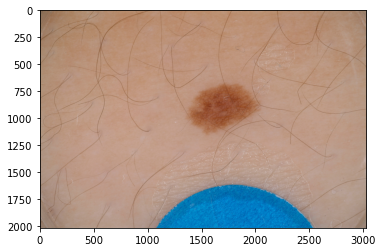

In [27]:
image = plt.imread(IMG_PATH + "ISIC_0001769.jpg")

image_mask = mask(image,120)

plt.imshow(image, cmap='gray');

In [28]:
# A color image is a array with 3 dimensions (x, y, R-G-B color channels) of integers

print(image.shape)
print(image.dtype)

(2016, 3024, 3)
uint8


[  0 121 196]


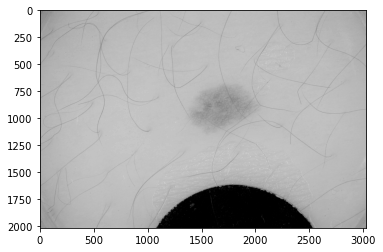

In [29]:
# Get a single RGB value from the blue circle (marker used by dermatologist)
print(image[2000,2000,:])

# Show only the red channel
plt.imshow(image[:,:,0], cmap='gray')

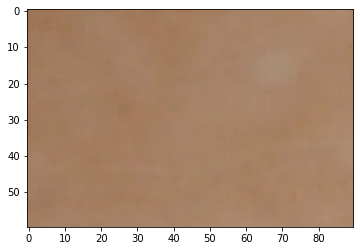

In [30]:
# Display only a part of the image
im_part = image[60:120,130:220,:]
plt.imshow(im_part)

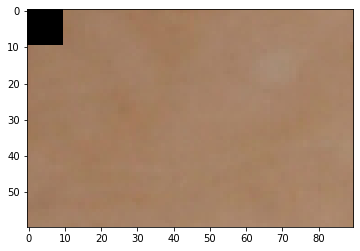

In [31]:
# Modify the image by setting some pixels to black
im_copy = im_part.copy()

im_copy[0:10,0:10,:] = np.tile(0, [10, 10, 3])
plt.imshow(im_copy)

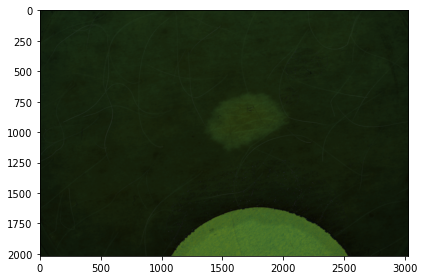

In [32]:
#experiment, not working as intended
edge_sobel = sobel(image)

plt.imshow(edge_sobel, cmap='gray')

plt.tight_layout()
plt.show()

## Load dataframes

In [33]:
truth = pd.read_csv(TRUTH)
truth.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [34]:
cancer = truth[truth['melanoma'] == 1]
cancer.head() #contains all the image id's that are cancerous

,image_id,melanoma,seborrheic_keratosis
25,ISIC_0012099,1.0,0.0
30,ISIC_0012151,1.0,0.0
42,ISIC_0012288,1.0,0.0
51,ISIC_0012434,1.0,0.0
73,ISIC_0013232,1.0,0.0


In [35]:
features = pd.read_csv(FEATURES)
features.head()

,id,area,perimeter
0,ISIC_0001769,216160.0,2013.0
1,ISIC_0001852,130493.0,1372.0
2,ISIC_0001871,205116.0,1720.0
3,ISIC_0003462,161705.0,1344.0
4,ISIC_0003539,317040.0,2063.0


In [36]:
truth[truth['image_id'] == IMG]

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
